Filtering DataFrame...
Number of unique users: 114838
Number of unique hashtags: 1500
Creating graph...
Added vertices...
Computing edges...
Adding edges...
Number of vertices:  116338
Number of edges:  1536300
Finding communities...
Number of communities:  8


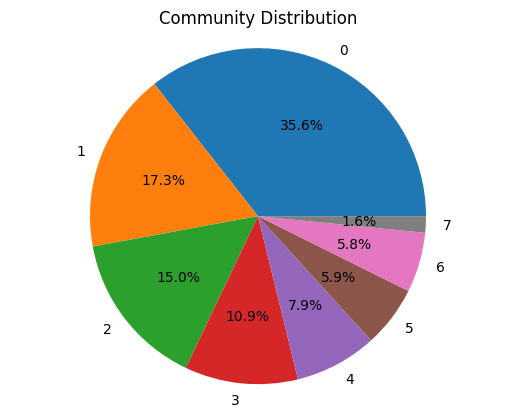

In [149]:
import os, yerbamate, ipdb
import pandas as pd
import igraph as ig
import leidenalg as la
import matplotlib.pyplot as plt

env = yerbamate.Environment()

path = os.path.join(env["plots"], "analysis", "user_hashtag_before.parquet")

df = pd.read_parquet(path)

print("Filtering DataFrame...")

hashtag_counts = df.groupby("hashtag").size().reset_index(name="counts")
top_hashtags = hashtag_counts.sort_values("counts", ascending=False).iloc[:1500]
# create a set of the top hashtags for faster lookup
top_hashtags_set = set(top_hashtags["hashtag"])

# filter the original DataFrame
df_filtered = df[df["hashtag"].isin(top_hashtags_set)]

df = df_filtered

# prrint number of unique users and hashtags
print(f"Number of unique users: {len(df['userId'].unique())}")
print(f"Number of unique hashtags: {len(df['hashtag'].unique())}")

print("Creating graph...")
# initialize a new graph
g = ig.Graph(directed=False)
# g.add_vertex(n=len(df["userId"].unique()), type="user")
# g.add_vertex(n=len(df["hashtag"].unique()), type="hashtag")
user_size = len(df["userId"].unique())


g.add_vertices(n=len(df["userId"].unique()) + len(df["hashtag"].unique()))

# set name of hashtags to be the hashtag itself
g.vs[user_size:]["name"] = df["hashtag"].unique()

# Add types for vertices
g.vs["type"] = [True if i < user_size else False for i in range(g.vcount())]


print("Added vertices...")
# map users and hashtags to unique integers
user_mapping = {user: i for i, user in enumerate(df["userId"].unique())}
hashtag_mapping = {
    hashtag: i + len(user_mapping) for i, hashtag in enumerate(df["hashtag"].unique())
}

print("Computing edges...")
# add edges
# edges = [
#     (user_mapping[row["userId"]], hashtag_mapping[row["hashtag"]])
#     for idx, row in df.iterrows()
# ]

df["user_id"] = df["userId"].map(user_mapping)
df["hashtag_id"] = df["hashtag"].map(hashtag_mapping)

# create the list of edges
edges = list(zip(df["user_id"], df["hashtag_id"]))

print("Adding edges...")

g.add_edges(edges)

weights = df["count"].values

# normalize the weights
weights = weights / weights.max()

g.es["weight"] = weights


# # add the edges with weights
# g.es["weight"] = weightsu

# # add the edges with weights
# g.es['weight'] = weights
print("Number of vertices: ", len(g.vs))
print("Number of edges: ", len(g.es))

print("Finding communities...")


# get the partition using the Leiden algorithm
import leidenalg as la

partition = la.find_partition(g, la.ModularityVertexPartition, weights= None)#g.es["weight"])

print("Number of communities: ", len(partition))

# add the partition to the graph
g.vs["partition"] = partition.membership

df['community'] =  df['user_id'].map( lambda x: g.vs[x]['partition'])

# Get the community sizes
community_sizes = partition.sizes()

# Plot the pie chart
plt.pie(community_sizes, labels=range(len(community_sizes)), autopct='%1.1f%%')
plt.title('Community Distribution')
plt.axis('equal')

# Show the chart
plt.show()

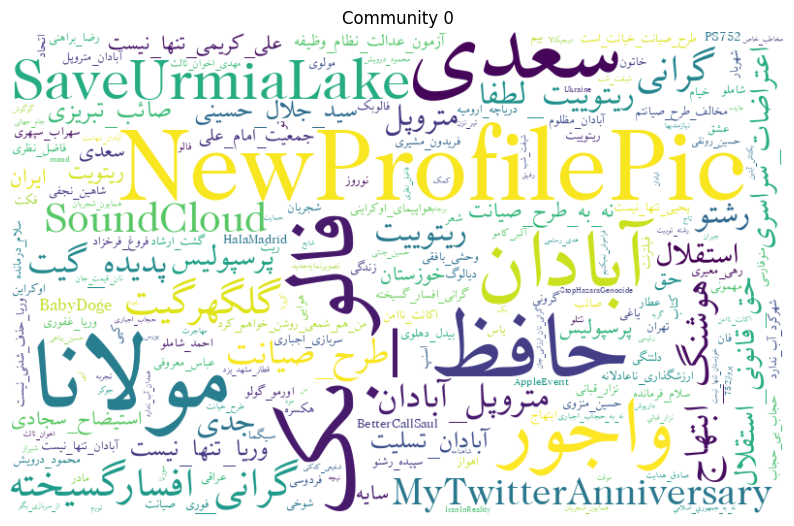

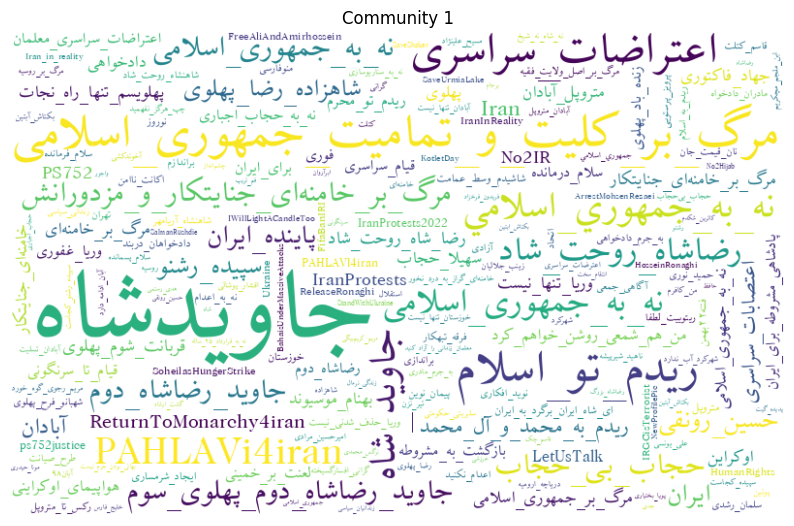

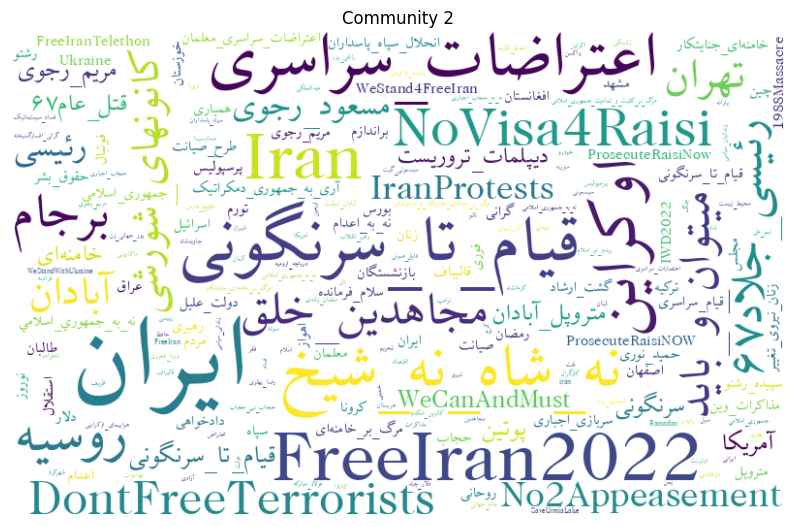

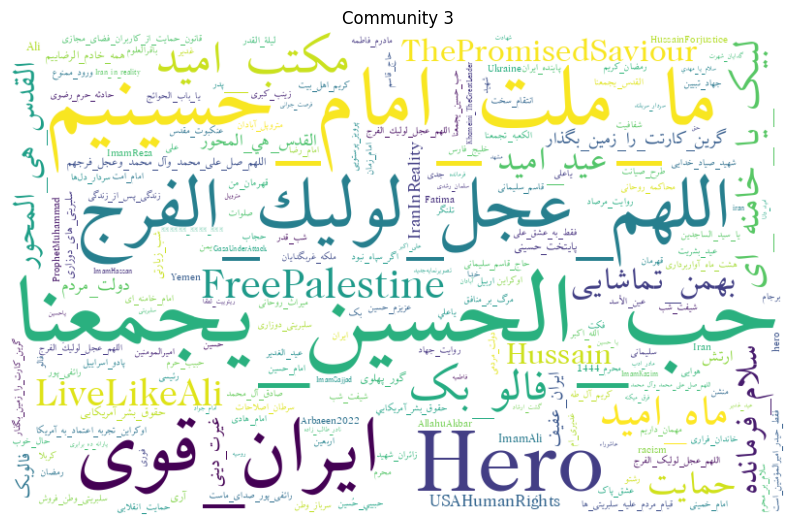

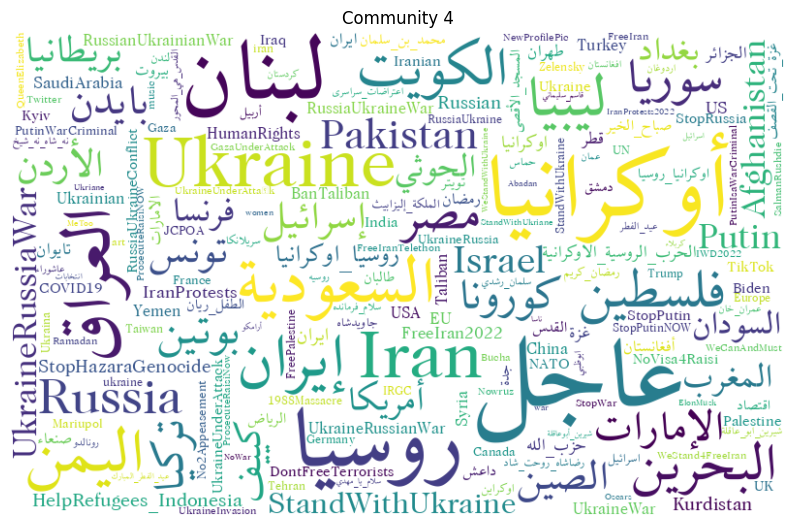

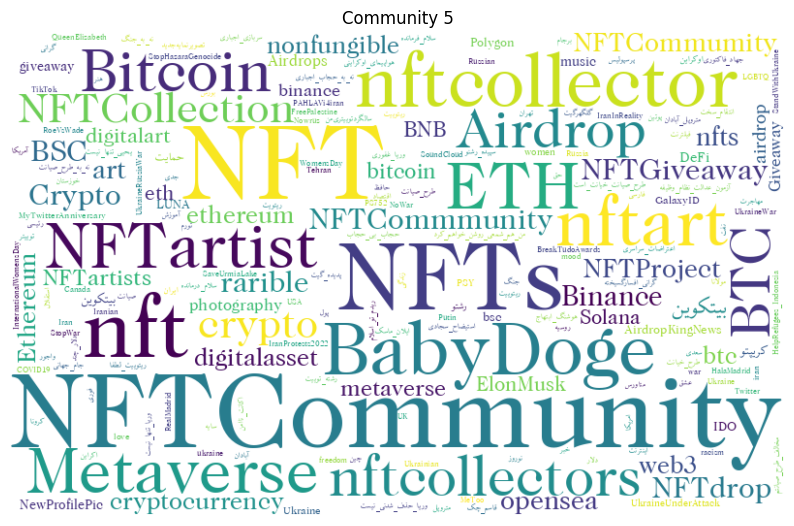

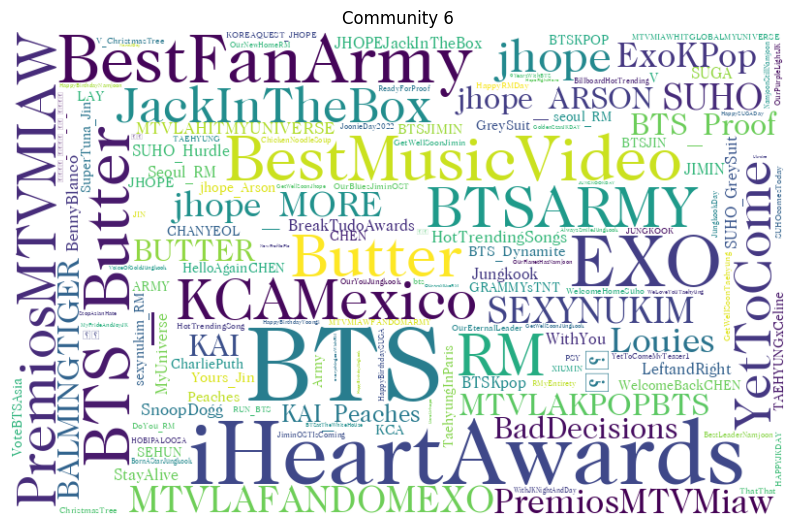

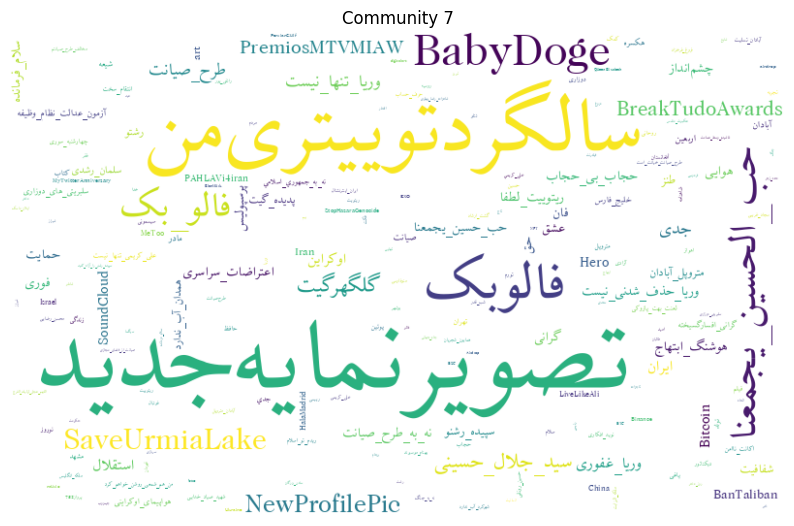

In [150]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["axes.unicode_minus"] = False
from bidi.algorithm import get_display
import arabic_reshaper

# assuming `df` is your DataFrame and it has a 'community' column
for community in sorted(df["community"].unique()):
    subset = df[df["community"] == community]
    # print(subset.columns)
    # #freq = subset.groupby("hashtag").count() 
    # # text = get_display(arabic_reshaper.reshape(text))
    # print(subset.head())
    # if subset.empty:
    #     print(f"No hashtags for community {community}. Skipping...")
    #     continue

    freq = subset.groupby("hashtag")["count"].sum()
    # print(freq)
    wordcloud = WordCloud(
        font_path="/usr/share/fonts/TTF/XB-Zar-Regular.ttf",
        width=800,
        height=500,
        random_state=21,
        max_font_size=110,
        background_color="white",
    ).generate_from_frequencies(freq)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Community {community}")
    plt.show()

In [129]:
hashtag_counts.sort_values("counts", ascending=False).head(20)

,hashtag,counts
196733,NewProfilePic,12090
658027,ایران,11534
490213,آبادان,11474
933710,سلام_فرمانده,8259
652066,اوکراین,8110
1120065,متروپل_آبادان,7950
1001165,طرح_صیانت,7863
189027,MyTwitterAnniversary,7690
1120061,متروپل,7088
948175,سپیده_رشنو,7051


In [152]:
graph_save_path = os.path.join(env['save'], 'graph', 'hashtag_communities')

# set name of hashtags to be the hashtag itself
g.vs[user_size:]["label"] = df["hashtag"].unique()

if not os.path.exists(graph_save_path):
    os.makedirs(graph_save_path)

g.save(os.path.join(graph_save_path, 'hashtag_communities_bipart.graphml'))


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["axes.unicode_minus"] = False
from bidi.algorithm import get_display
import arabic_reshaper

# assuming `df` is your DataFrame and it has a 'community' column
for community in sorted(df["community"].unique()):
    subset = df[df["community"] == community]
    # print(subset.columns)
    # #freq = subset.groupby("hashtag").count() 
    # # text = get_display(arabic_reshaper.reshape(text))
    # print(subset.head())
    # if subset.empty:
    #     print(f"No hashtags for community {community}. Skipping...")
    #     continue

    freq = subset.groupby("hashtag")["count"].sum()
    # print(freq)
    wordcloud = WordCloud(
        font_path="/usr/share/fonts/TTF/XB-Zar-Regular.ttf",
        width=800,
        height=500,
        random_state=21,
        max_font_size=110,
        background_color="white",
    ).generate_from_frequencies(freq)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Community {community}")
    plt.show()

In [33]:
sample_size = 4500

# 2. Sample nodes
# Group nodes by community
groups = df.groupby('community')

# Sample from each group
sampled_nodes = groups.apply(lambda x: x.sample(n=int((x['userId'].nunique()/df['userId'].nunique())*sample_size)))

# Get the unique sampled userIds
sampled_ids = sampled_nodes['userId'].unique()

# 3. Create a subgraph
# Get the vertex indices corresponding to the sampled user Ids
vertex_indices = [g.vs.find(name=str(i)).index for i in sampled_ids if str(i) in g.vs['name']]

# Create a subgraph
subgraph = g.subgraph(vertex_indices)

# Plot the subgraph


In [34]:
import networkx as nx
from pyvis.network import Network


# Convert igraph to networkx
G_nx = ig.Graph.to_networkx(subgraph)

# Create a pyvis network
G_pyvis = Network(notebook=True)
G_pyvis.from_nx(G_nx)

# Show the network
G_pyvis.show("graph.html")

graph.html
